In [1]:
import numpy as np
import matplotlib.pyplot as plt
from few.waveform import GenerateEMRIWaveform, FastSchwarzschildEccentricFlux, FastKerrEccentricEquatorialFlux
from few.utils.constants import Gpc, MRSUN_SI, YRSID_SI
from typing import Optional, Union, Callable
from tqdm import tqdm

#try:
#    import cupy as cp
#    use_gpu = True
#except ImportError():
#    print("Not on GPU")
#    use_gpu = False

use_gpu = True

from stableemrifisher.fisher.fisher import StableEMRIFisher
from stableemrifisher.utils import inner_product

from fastlisaresponse import ResponseWrapper  # Response function 
from lisatools.detector import ESAOrbits #ESAOrbits correspond to esa-trailing-orbits.h5
from lisatools.sensitivity import get_sensitivity, A1TDISens, E1TDISens, T1TDISens

if not use_gpu:
    
    import few
    
    #tune few configuration
    cfg_set = few.get_config_setter(reset=True)
    
    cfg_set.enable_backends("cpu")
    cfg_set.set_log_level("info");
    force_backend = 'cpu'
else:
    force_backend = 'gpu'
    pass #let the backend decide for itself.

startup


In [2]:
#waveform class setup
waveform_class = FastSchwarzschildEccentricFlux
waveform_class_kwargs = dict(inspiral_kwargs=dict(err=1e-11,),
                             mode_selector_kwargs=dict(mode_selection_threshold=1e-5))

#waveform generator setup
waveform_generator = GenerateEMRIWaveform
waveform_generator_kwargs = dict(return_list=False)

#ResponseWrapper setup
ResponseWrapper = ResponseWrapper
tdi_gen ="1st generation"# "2nd generation"#
order = 20  # interpolation order (should not change the result too much)
tdi_kwargs_esa = dict(
    orbits=ESAOrbits(use_gpu=use_gpu), order=order, tdi=tdi_gen, tdi_chan="AE",
)  # could do "AET"
index_lambda = 8
index_beta = 7
# with longer signals we care less about this
t0 = 10000.0  # throw away on both ends when our orbital information is weird
T = 0.1
dt = 10.0

ResponseWrapper_kwargs = dict(
    #waveform_gen=waveform_generator,
    Tobs = T,
    dt = dt,
    index_lambda = index_lambda,
    index_beta = index_beta,
    t0 = t0,
    flip_hx = True,
    use_gpu=use_gpu,
    is_ecliptic_latitude=False,
    remove_garbage="zero",
    **tdi_kwargs_esa
)

#noise setup
channels = [A1TDISens, E1TDISens]
noise_model = get_sensitivity
noise_kwargs = [{"sens_fn": channel_i} for channel_i in channels]

In [3]:
sef = StableEMRIFisher(waveform_class=waveform_class, 
                       waveform_class_kwargs=waveform_class_kwargs,
                       waveform_generator=waveform_generator,
                       waveform_generator_kwargs=waveform_generator_kwargs,
                       ResponseWrapper=ResponseWrapper, ResponseWrapper_kwargs=ResponseWrapper_kwargs,
                       noise_model=noise_model, noise_kwargs=noise_kwargs, channels=channels,
                      stats_for_nerds = True, use_gpu = use_gpu,
                      deriv_type='stable')

In [4]:
m1 = 1e6
m2 = 1e1
a = 0.
p0 = 9.5
e0 = 0.4
xI0 = 1.0
dist = 0.1
qS = np.pi/3
phiS = np.pi/4
qK = np.pi/6
phiK = np.pi/8
Phi_phi0 = 1.0
Phi_theta0 = 0.0
Phi_r0 = 0.0

pars_list = [m1, m2, a, p0, e0, xI0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
param_names = ['dist','qS','phiS','qK','phiK','Phi_phi0','Phi_r0']

der_order = 4
Ndelta = 8
stability_plot = True

delta_range = dict(
    m1 = np.geomspace(1e-4*m1, 1e-9*m1, Ndelta),
    m2 = np.geomspace(1e-2*m2, 1e-7*m2, Ndelta),
    p0 = np.geomspace(1e-2*p0, 1e-7*p0, Ndelta),
    e0 = np.geomspace(1e-1*e0, 1e-7*e0, Ndelta),
    qS = np.geomspace(1e-4,    1e-9,    Ndelta),
    phiS = np.geomspace(1e-4,    1e-9,    Ndelta),
    qK = np.geomspace(1e-4,    1e-9,    Ndelta),
    phiK = np.geomspace(1e-4,    1e-9,    Ndelta),
)

Fisher = sef(*pars_list, param_names = param_names, 
             T = T, dt = dt, 
             der_order = der_order, 
             Ndelta = Ndelta, 
             stability_plot = stability_plot,
             delta_range = delta_range,
            live_dangerously = True)

Body is not plunging, Fisher should be stable.
wave ndim: 2
Computing SNR for parameters: {'m1': 1000000.0, 'm2': 10.0, 'a': 0.0, 'p0': 9.5, 'e0': 0.4, 'xI0': 1.0, 'dist': 0.1, 'qS': 1.0471975511965976, 'phiS': 0.7853981633974483, 'qK': 0.5235987755982988, 'phiK': 0.39269908169872414, 'Phi_phi0': 1.0, 'Phi_theta0': 0.0, 'Phi_r0': 0.0}
Waveform Generated. SNR: 119.32881779777304
You have elected for dangerous living, I like it. 
calculating Fisher matrix...
qS dtype: float64 dtv_i:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
phiS dtype: float64 dtv_i:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
qK dtype: float64 dtv_i:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
phiK dtype: float64 dtv_i:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Finished derivatives
dtypes: float64 float64
dtypes: float64 float64
dtypes: float64 float64
dtypes: float64 float64
dtypes: float64 float64
dtypes: float64 float64
dtypes: float64 float64
dtypes: float64 float64
dtypes: float6

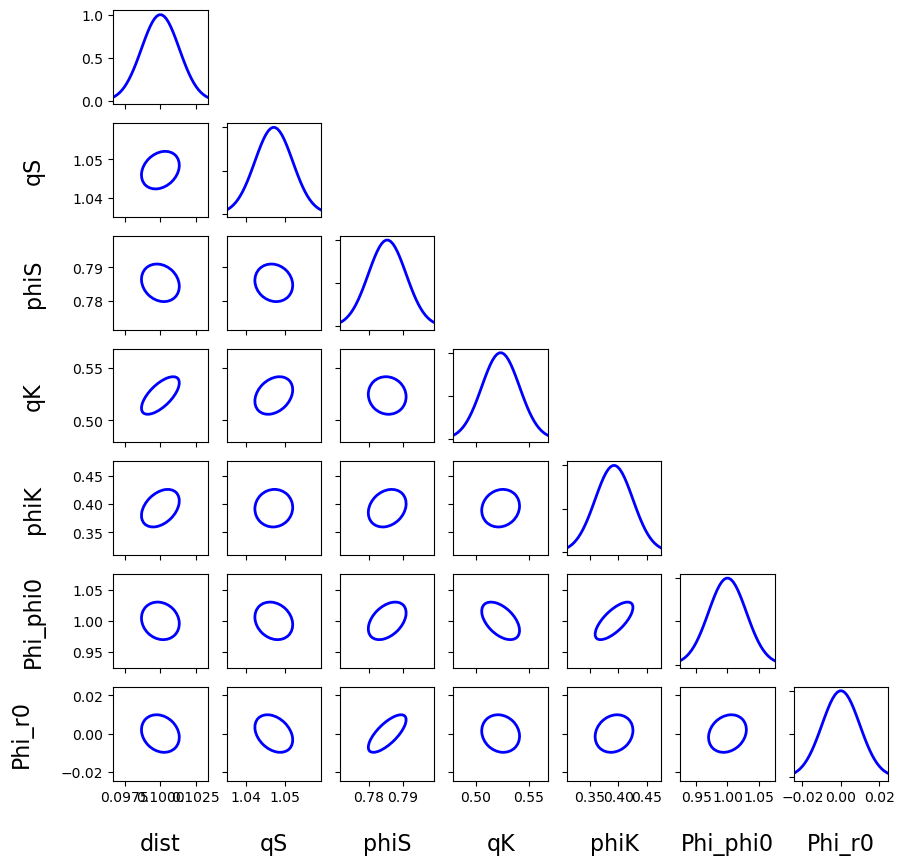

In [5]:
from stableemrifisher.plot import CovEllipsePlot

pars_list = [m1, m2, a, p0, e0, xI0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
pars_name = ['m1','m2','a','p0','e0','xI0','dist','qS','phiS','qK','phiK','Phi_phi0','Phi_theta0','Phi_r0']

wave_params = {}
for i in range(len(pars_list)):
    wave_params[pars_name[i]] = pars_list[i]
    
param_names = param_names

covariance = np.linalg.inv(Fisher)

ellipse_kwargs = dict(facecolor='None', edgecolor='b', lw=2)
line_kwargs = dict(lw=2, color='b')

fig, axs = plt.subplots(len(covariance),len(covariance), figsize=(10,10))
fig, axs = CovEllipsePlot(covariance, wave_params=wave_params, param_names=param_names, fig=fig, axs=axs, ellipse_kwargs=ellipse_kwargs, line_kwargs=line_kwargs)

In [40]:
if sef.deriv_type == 'stable': 
    if not sef.has_ResponseWrapper:
        Npad = sef.derivative.cache['Npad'] if sef.derivative.cache['Npad'] > 0 else 1
    else:
        try:
            Npad = sef.derivative.waveform_gen.cache['Npad'] if sef.derivative.waveform_gen.cache['Npad'] > 0 else 1
        except TypeError: #cache might be nonetype if direct derivatives are calculated, e.g. for the angles
            Npad = 1
else:
    Npad = 1

In [9]:
#initialize response wrapper

wave_gen_base = waveform_generator(waveform_class=waveform_class,
                                   **sef.waveform_generator_kwargs)

wave_gen_resp = ResponseWrapper(
    waveform_gen = wave_gen_base,
    **ResponseWrapper_kwargs
)

In [41]:
if use_gpu:
    import cupy as cp
    xp = cp
else:
    xp = np
    
wave = xp.asarray([xp.concatenate((sef.waveform[i][:-Npad], xp.zeros(Npad)), dtype = sef.waveform.dtype) for i in range(len(sef.waveform))])

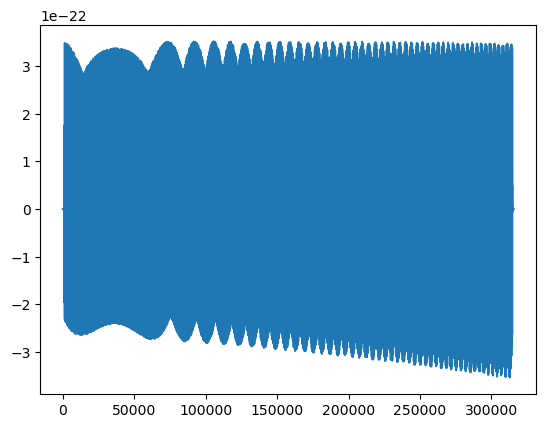

In [42]:
plt.plot(wave.get()[0])

In [43]:
def Fisher_1D(partialh):
    return inner_product(partialh, partialh, PSD = PSD, dt = dt, use_gpu=use_gpu)

sigma1D = 1/np.sqrt(Fisher[0,0])
print(f"sigma", sigma1D)
PSD = sef.PSD_funcs

def likelihood(h_inj, h_temp):
    if len(h_inj) == 1:
        delta = h_inj - h_temp
        delta = [delta.real, -delta.imag]
    else:
        delta = [h_inj[i] - h_temp[i] for i in range(len(h_inj))]
        
    return np.exp(-0.5 * inner_product(delta, delta, PSD = PSD, dt = dt, use_gpu=use_gpu))

N = 50

param_to_vary_range = np.linspace(sef.wave_params[param_names[0]] - 4 * sigma1D, sef.wave_params[param_names[0]] + 4 * sigma1D, N)

likes = []

for i in tqdm(range(N)):
    parameters_in = sef.wave_params.copy()
    parameters_in[param_names[0]] = param_to_vary_range[i]
    parameters_in_list = list(parameters_in.values())
    htemp = xp.asarray(wave_gen_resp(
        *parameters_in_list,
        dt=dt, 
        T=T,
    ))

    htemp = xp.asarray([xp.concatenate((htemp[nchan][:-Npad], xp.zeros(Npad)), dtype = htemp.dtype) for nchan in range(len(channels))])

    #plt.plot(htemp.get()[0])
    #plt.plot(wave.get()[0], '--')
    #plt.show()
    
    likes.append(likelihood(wave, htemp))

sigma 0.0028544897404824644


100%|███████████████████████████████████████████| 50/50 [00:07<00:00,  6.95it/s]


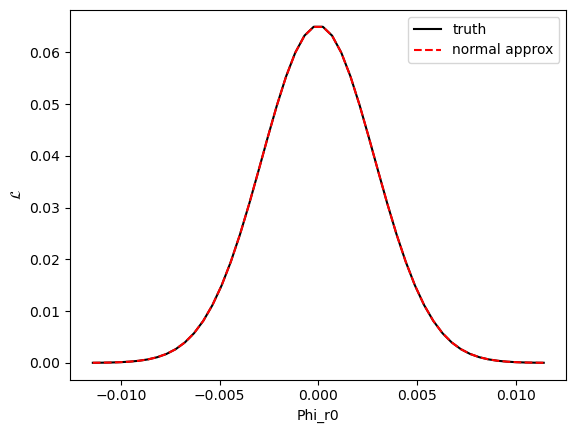

In [44]:
from scipy.stats import norm

normal_approx = norm.pdf(param_to_vary_range, loc = sef.wave_params[param_names[0]], scale = sigma1D)
normal_approx /= np.sum(normal_approx)
plt.plot(param_to_vary_range, likes/np.sum(likes), c='k', label='truth')
plt.plot(param_to_vary_range, normal_approx, c='r', label='normal approx', linestyle='--')
plt.legend()
plt.ylabel(r'$\mathcal{L}$')
plt.xlabel(param_names[0])
plt.savefig(f'1D_like_vs_NA_{param_names[0]}.png', dpi = 300, bbox_inches='tight')
plt.show()